# Linear Regression, KNN, LGBM, XGB, Random Forest, SVR/Linear-SVR  - <br /> by Jerome, 03 December2021 #

---

In [6]:
## load modules
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from modeling.functions import modelling, log_to_mlflow, get_features, baseline, modelling_fc, baseline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pickle 
import ast 


RSEED = 42


### Read data, remove NaNs and get dummies for cardinal wind directions ###

In [7]:
## read data
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')
data.interpolate(method='linear', inplace=True)
data = pd.get_dummies(data, columns = ['WD100CARD','WD10CARD'], drop_first=True)
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175440 entries, 2012-01-01 01:00:00 to 2014-01-01 00:00:00
Data columns (total 46 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ZONEID         175440 non-null  int64  
 1   TARGETVAR      175440 non-null  float64
 2   U10            175440 non-null  float64
 3   V10            175440 non-null  float64
 4   U100           175440 non-null  float64
 5   V100           175440 non-null  float64
 6   HOUR           175440 non-null  int64  
 7   MONTH          175440 non-null  int64  
 8   WEEKDAY        175440 non-null  int64  
 9   IS_HOLIDAY     175440 non-null  int64  
 10  WS10           175440 non-null  float64
 11  WS100          175440 non-null  float64
 12  WD10           175440 non-null  float64
 13  WD100          175440 non-null  float64
 14  U100NORM       175440 non-null  float64
 15  V100NORM       175440 non-null  float64
 16  WD100CARD_ENE  175440 non-null  uint8  


,ZONEID,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,IS_HOLIDAY,...,WD10CARD_NNW,WD10CARD_NW,WD10CARD_S,WD10CARD_SE,WD10CARD_SSE,WD10CARD_SSW,WD10CARD_SW,WD10CARD_W,WD10CARD_WNW,WD10CARD_WSW
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,1,0.000000,2.124600,-2.681966,2.864280,-3.666076,1,1,6,1,...,0,1,0,0,0,0,0,0,0,0
2012-01-01 02:00:00,1,0.054879,2.521695,-1.796960,3.344859,-2.464761,2,1,6,1,...,0,1,0,0,0,0,0,0,0,0
2012-01-01 03:00:00,1,0.110234,2.672210,-0.822516,3.508448,-1.214093,3,1,6,1,...,0,0,0,0,0,0,0,0,1,0
2012-01-01 04:00:00,1,0.165116,2.457504,-0.143642,3.215233,-0.355546,4,1,6,1,...,0,0,0,0,0,0,0,1,0,0
2012-01-01 05:00:00,1,0.156940,2.245898,0.389576,2.957678,0.332701,5,1,6,1,...,0,0,0,0,0,0,0,1,0,0


In [8]:
data.IS_HOLIDAY.unique()

array([1, 0])

### Train-test-split, get different combinations of features and run different models with them ###

In [9]:
## train-test-split and get features and zones
data_train = data[:'2013-07-01 00:00:00']
data_test = data['2013-07-01 01:00:00':]
feature_dict = get_features(data)

In [10]:
data_test.TARGETVAR.mean()
#data_train.IS_HOLIDAY.unique()

0.41253088285532546

In [11]:
# ## run different models and save scores in csv file
#models = [LGBMRegressor(random_state=RSEED)]
#models = [KNeighborsRegressor()]
models = ['Baseline']

for model in models:

    # Baseline
    if model == 'Baseline':
        results = baseline(data_train, data_test)

    # RandomForest
    if model.__class__.__name__ == 'RandomForestRegressor':
        param_grid = {'n_estimators' : [100,150], 'max_depth' : np.arange(15,31,5), 'min_samples_leaf' : np.arange(10,21,10)}
        results = modelling_fc(data_train, data_test, feature_dict, model, param_grid = param_grid, scaler=MinMaxScaler(), n_jobs=3)

    # Linear regression
    if model.__class__.__name__ == 'LinearRegression':
        param_grid = {'fit_intercept' : [True]}
        results = modelling_fc(data_train, data_test, feature_dict, model, param_grid = param_grid, scaler=MinMaxScaler(), n_jobs=-1)

    # XGBoost
    if model.__class__.__name__ == 'XGBRegressor':
        param_grid = {'random_state' : [RSEED]}
        results = modelling_fc(data_train, data_test, feature_dict, model, param_grid = param_grid, scaler = MinMaxScaler(), n_jobs=-1)

    # LGBM
    if model.__class__.__name__ == 'LGBMRegressor':
        param_grid = [{'n_estimators' : [100]},
                      {'n_estimators' : [1000], 'num_leaves' : [20]},
                      {'n_estimators' : [50], 'num_leaves': [62]}]
        results = modelling_fc(data_train, data_test, feature_dict, model, param_grid = param_grid, scaler = MinMaxScaler(), n_jobs=-1)

    # KNN
    if model.__class__.__name__ == 'KNeighborsRegressor': 
        param_grid = {'n_neighbors' : np.arange(20,141,10), 'weights' : ['uniform','distance'], 'p' : [1,2]}
        results = modelling_fc(data_train, data_test, feature_dict, model, scaler = MinMaxScaler(), param_grid = param_grid)

    # remove file before new file is created
    if os.path.isfile(f'../results/{results.MODEL.iloc[1]}.csv'):
        os.remove(f'../results/{results.MODEL.iloc[1]}.csv')

    # save results in csv file
    results.to_csv(f'../results/{results.MODEL.iloc[1]}.csv')

In [12]:
results

,BEST_PARAMS,CV,MODEL,FC,TESTSCORE,TRAINSCORE
ZONE,,,,,,
ZONE1,NaN,NaN,Baseline,NaN,0.330221,0.274462
ZONE2,NaN,NaN,Baseline,NaN,0.290033,0.256417
ZONE3,NaN,NaN,Baseline,NaN,0.312627,0.296552
ZONE4,NaN,NaN,Baseline,NaN,0.366647,0.31975
ZONE5,NaN,NaN,Baseline,NaN,0.361371,0.326282
ZONE6,NaN,NaN,Baseline,NaN,0.355799,0.331287
ZONE7,NaN,NaN,Baseline,NaN,0.307106,0.251734
ZONE8,NaN,NaN,Baseline,NaN,0.316515,0.262741
ZONE9,NaN,NaN,Baseline,NaN,0.312423,0.276838


In [13]:
0.30 / data_train.TARGETVAR.mean()

0.8813662815784139

Text(0.5, 1.0, 'Average electricity production by wind farm')

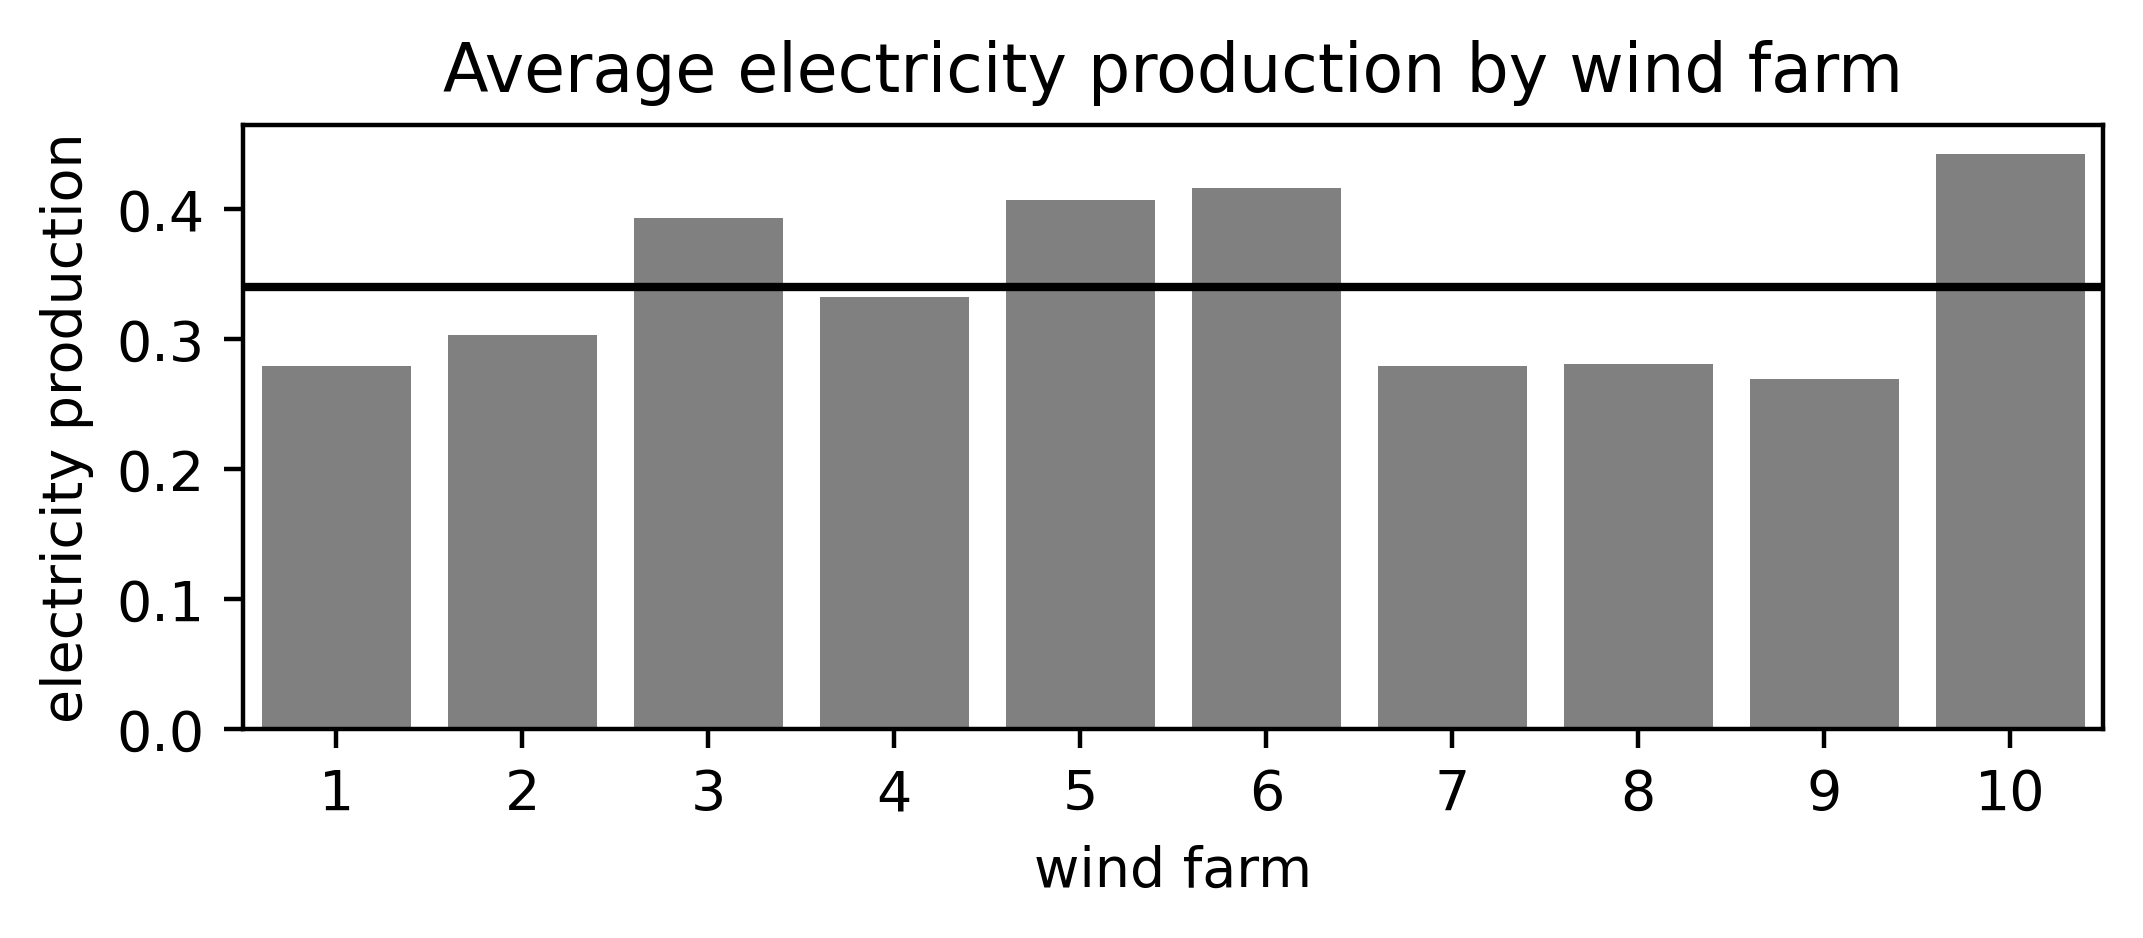

In [14]:
fig,ax = plt.subplots(dpi=400, figsize=(6,2))
sns.barplot(data = data_train, x = 'ZONEID', y = 'TARGETVAR', ax=ax, color='gray', ci=None)
ax.set_xlabel('wind farm')
ax.set_ylabel('electricity production')
ax.axhline(y=data_train.TARGETVAR.mean(), color='k')
ax.set_title('Average electricity production by wind farm')

In [15]:
df = pd.read_csv(f'../results/RandomForestRegressor.csv', index_col='ZONE')
[(ast.literal_eval(values)['n_estimators'], ast.literal_eval(values)['max_depth'],ast.literal_eval(values)['min_samples_leaf']) for values in df.BEST_PARAMS]

[(150, 20, 20),
 (100, 20, 20),
 (150, 20, 20),
 (150, 30, 10),
 (150, 15, 20),
 (150, 25, 20),
 (150, 20, 10),
 (150, 20, 20),
 (150, 15, 20),
 (150, 15, 20)]

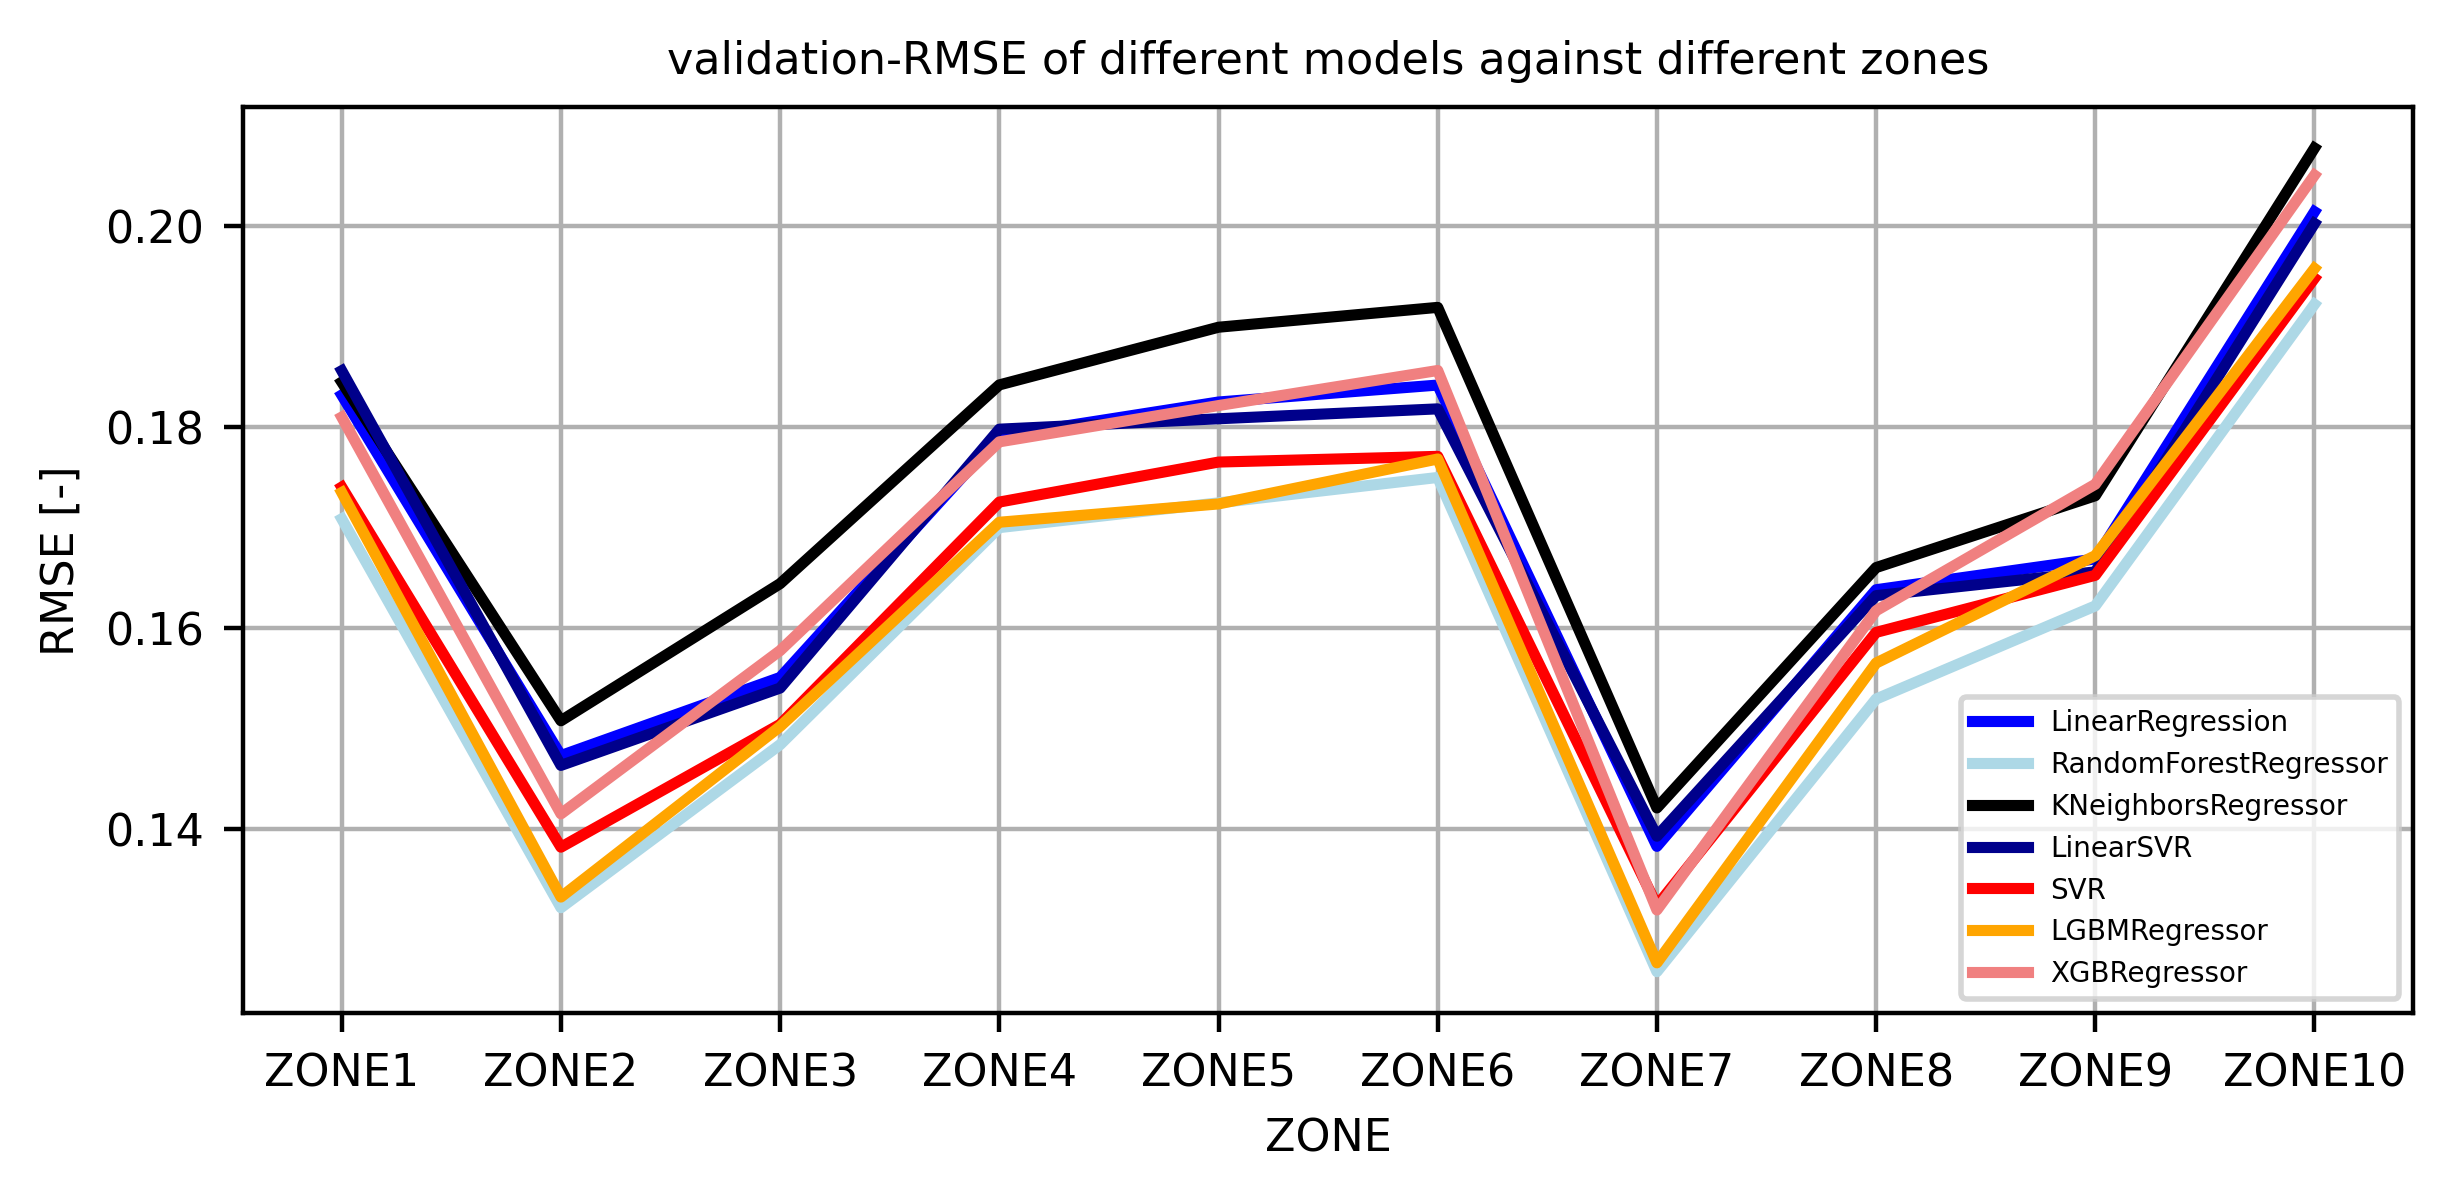

In [16]:
## plot RMSE for different models (best feature combination) against different zones
models = ['LinearRegression', 'RandomForestRegressor', 'KNeighborsRegressor', 'LinearSVR', 'SVR', 'LGBMRegressor', 'XGBRegressor']

linewidth, fontsize = 2, 8
colors = ['b','lightblue','k','darkblue','r', 'orange', 'lightcoral']
fig, ax = plt.subplots(dpi=400, figsize=(7,3))

for i,model in enumerate(models):
    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')
    ax.plot(df.index, df.CV, color = colors[i], linewidth=linewidth)

ax.grid()
ax.tick_params(labelsize=fontsize)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.set_xlabel('ZONE', fontsize=fontsize)

ax.legend(['{}'.format(model) for model in models], fontsize = fontsize-3)
ax.set_title('validation-RMSE of different models against different zones', fontsize=fontsize);

fig.savefig('../images/VAL-RMSE_ZONES.png')

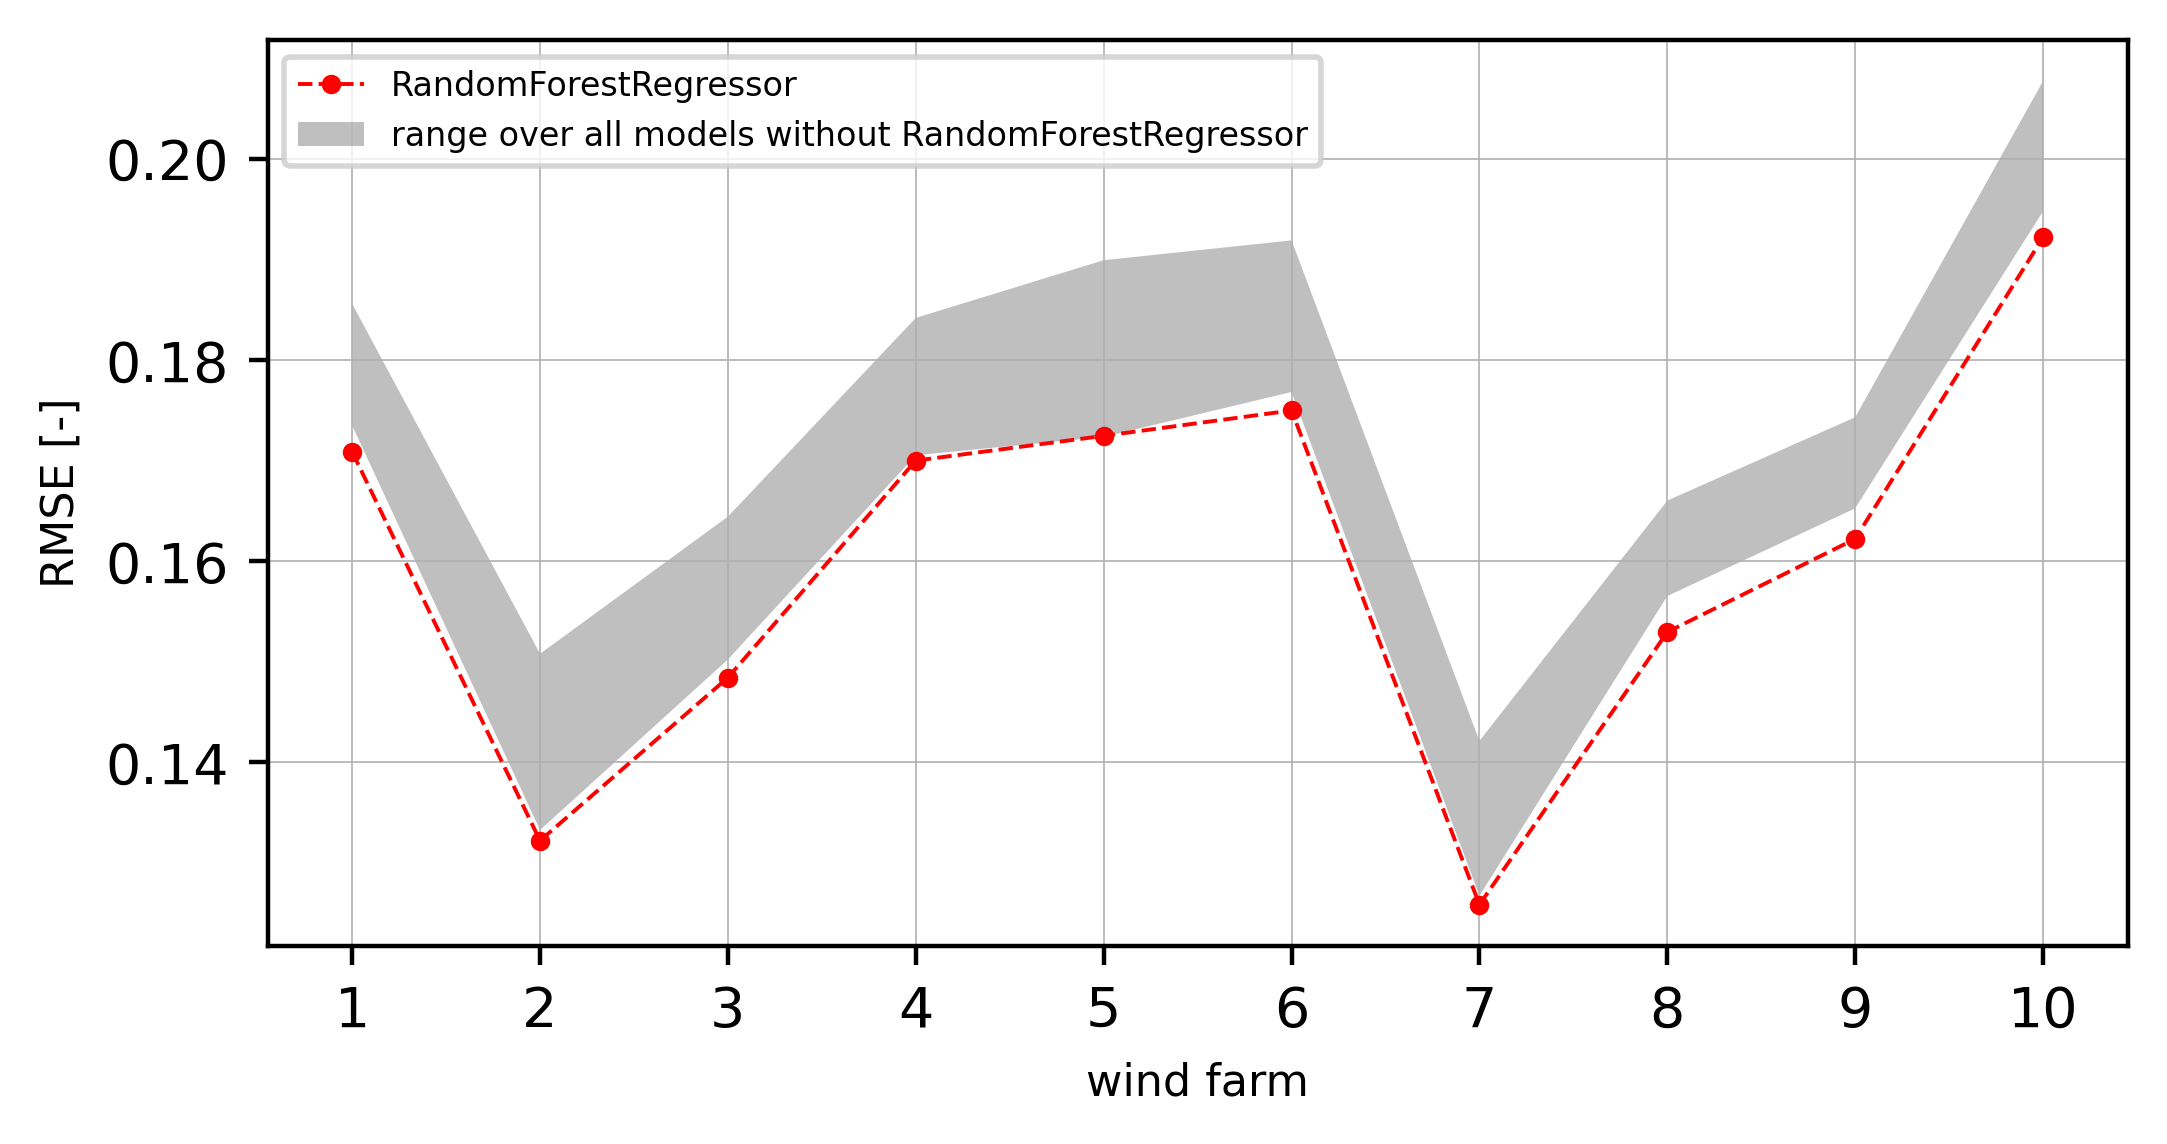

In [17]:
## RMSE by wind farm
results = pd.DataFrame(columns = ['ZONE','MODEL','VALSCORE'])
results.set_index('ZONE', inplace=True)
models = ['Baseline','LinearRegression', 'KNeighborsRegressor', 'RandomForestRegressor','LinearSVR', 'SVR', 'LGBMRegressor', 'XGBRegressor']
for model in models:
    #df.append(pd.read_csv(f'../results/{model}.csv', index_col='ZONE'))
    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')
    df = df[['CV','MODEL']]
    df.rename(columns={'CV':'VALSCORE'}, inplace=True)
    results = results.append(df) 

results = results.loc[results.index != 'TOTAL']

df = results[results.MODEL=='RandomForestRegressor'][['VALSCORE']]
results = results[results.MODEL != 'RandomForestRegressor']
df['MINVAL'] = [results.loc[zone]['VALSCORE'].min() for zone in df.index]
df['MAXVAL'] = [results.loc[zone]['VALSCORE'].max() for zone in df.index]

fig, ax = plt.subplots(dpi=400, figsize=(6,3))
ax.plot(df.index.unique(), df['VALSCORE'], color='r', linestyle='--', marker='.', markersize=5, linewidth=.7)
ax.fill_between(df.index.unique(), df['MINVAL'], df['MAXVAL'], color = 'gray', alpha=.5, edgecolor=None);
ax.set_xlabel('wind farm',fontsize=fontsize)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.grid(linewidth=.3)
ax.legend(['RandomForestRegressor','range over all models without RandomForestRegressor'], fontsize=fontsize - 2, loc = 'upper left')
ax.set_xticklabels([zone[-1] if len(zone) == 5 else zone[-2:] for zone in df.index]);



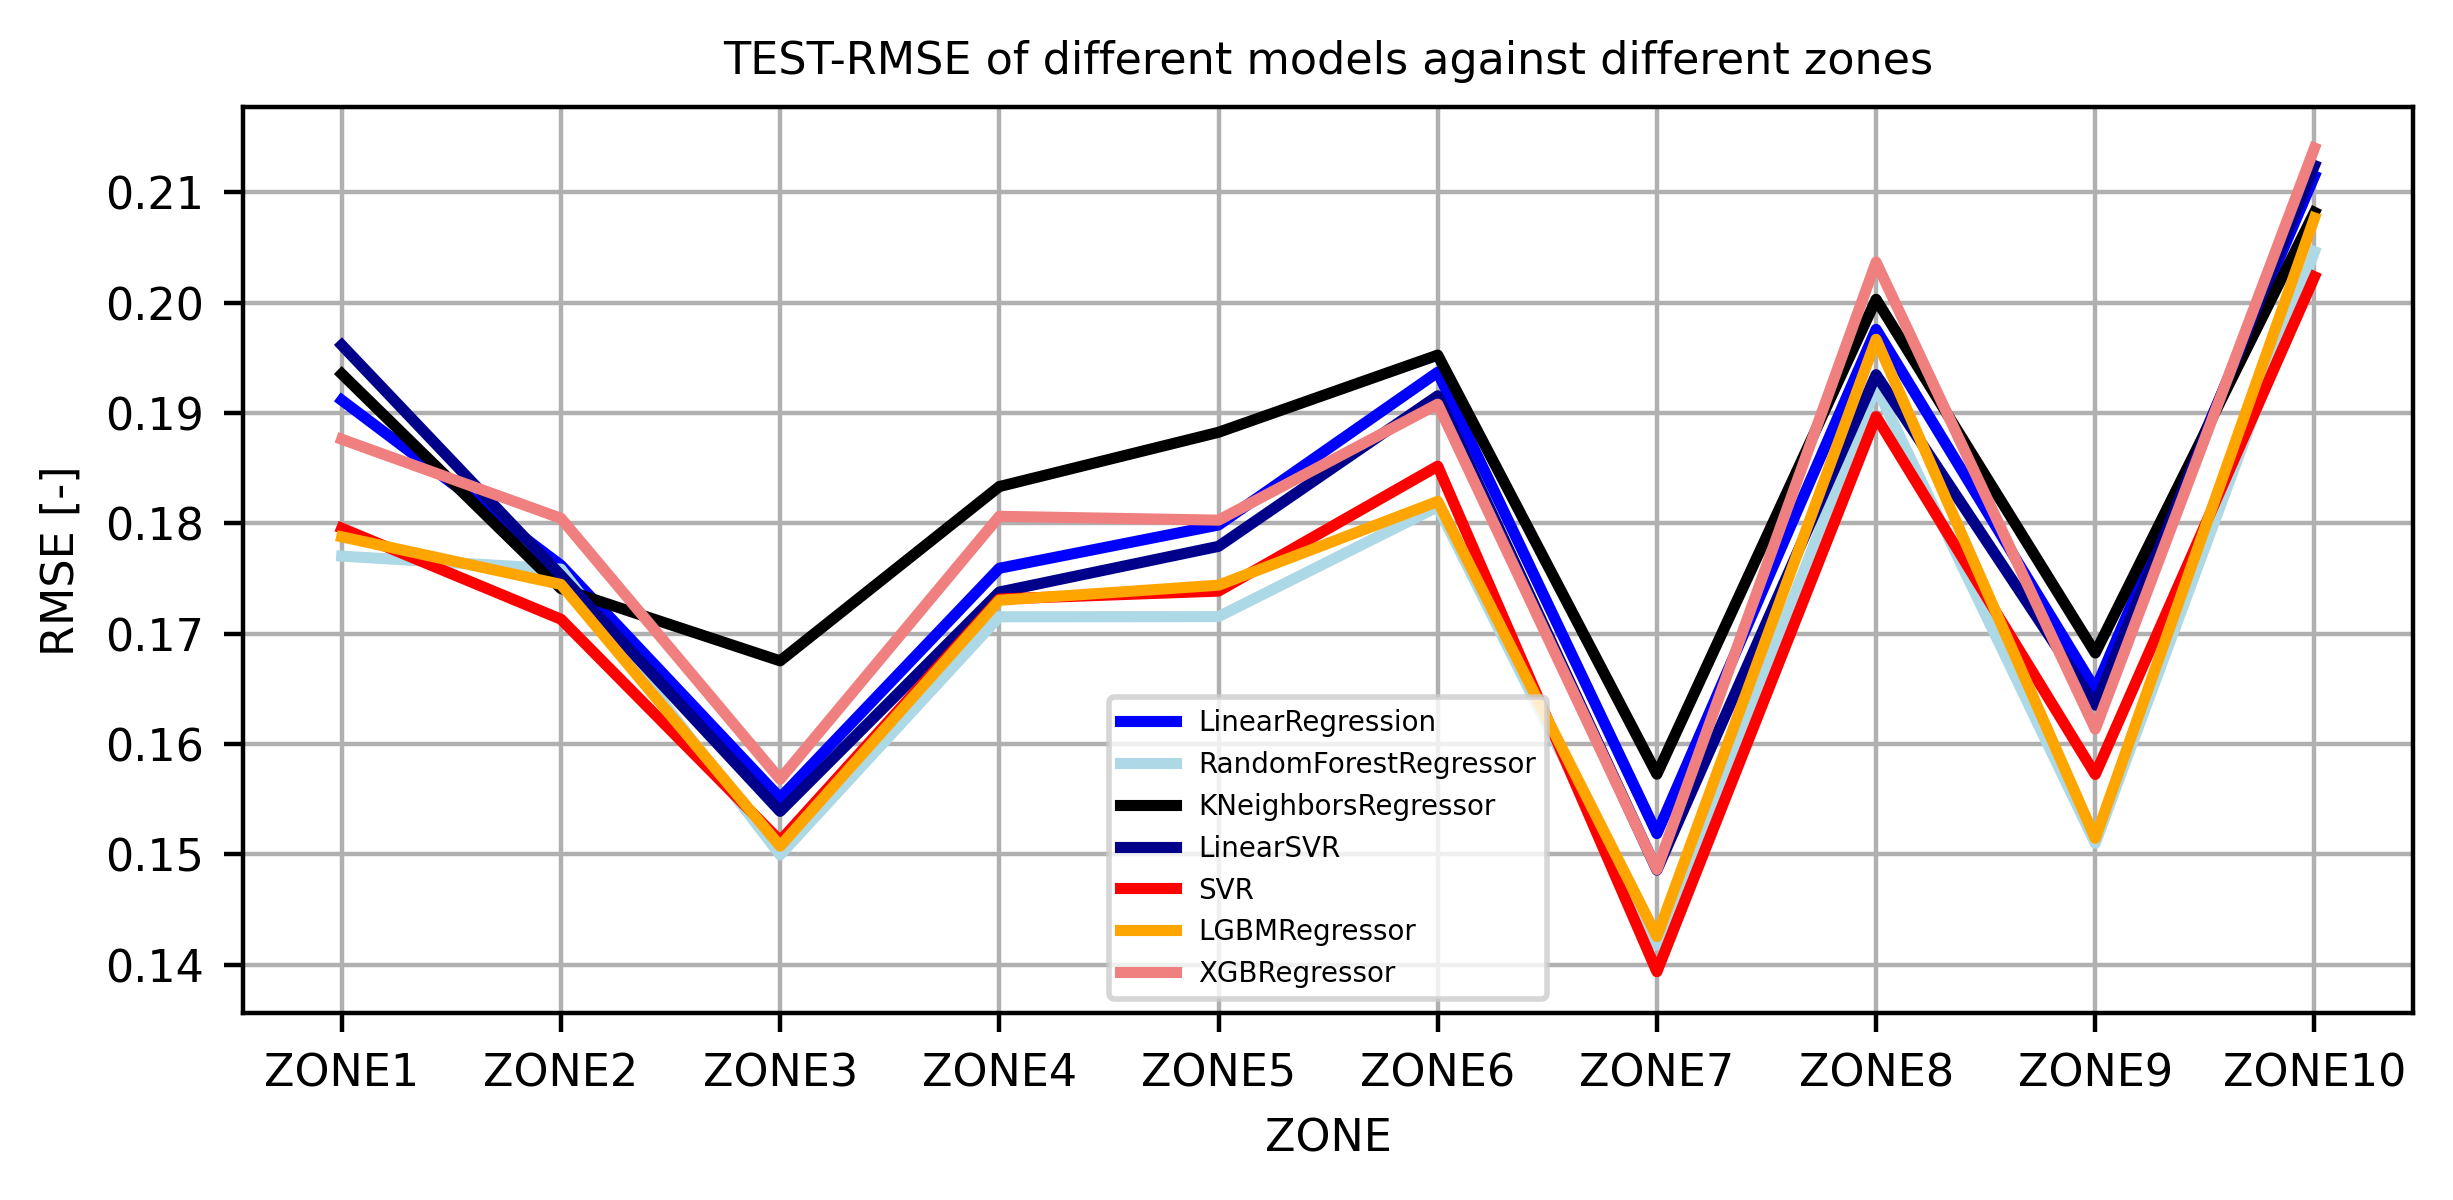

In [18]:
## plot RMSE for different models (best feature combination) against different zones
models = ['LinearRegression', 'RandomForestRegressor', 'KNeighborsRegressor', 'LinearSVR', 'SVR', 'LGBMRegressor', 'XGBRegressor']

linewidth, fontsize = 2, 8
colors = ['b','lightblue','k','darkblue','r', 'orange', 'lightcoral']
fig, ax = plt.subplots(dpi=400, figsize=(7,3))

for i,model in enumerate(models):
    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')
    ax.plot(df.index, df.TESTSCORE, color = colors[i], linewidth=linewidth)

ax.grid()
ax.tick_params(labelsize=fontsize)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.set_xlabel('ZONE', fontsize=fontsize)

ax.legend(['{}'.format(model) for model in models], fontsize = fontsize-3)
ax.set_title('TEST-RMSE of different models against different zones', fontsize=fontsize);

fig.savefig('../images/TEST-RMSE_ZONES.png')

In [19]:
models = ['Baseline','LinearRegression', 'KNeighborsRegressor', 'RandomForestRegressor','LinearSVR', 'SVR', 'LGBMRegressor', 'XGBRegressor']

total = pd.DataFrame(index = models, columns = ['TESTSCORE','VALSCORE', 'RELVAL'])

for model in models:
    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')
    if model != 'Baseline':
        total.loc[model]['TESTSCORE'] = np.sqrt(np.mean(df.TESTSCORE**2))
        total.loc[model]['VALSCORE'] = np.sqrt(np.mean(df.CV**2))
    else:
        total.loc[model]['VALSCORE'] = df.loc['TOTAL'].TRAINSCORE
        total.loc[model]['TESTSCORE'] = df.loc['TOTAL'].TESTSCORE
    total.loc[model]['RELVAL'] = total.loc[model]['VALSCORE'] / data_train.TARGETVAR.mean()
#total = total.sort_values(by='VALSCORE', ascending=False)
        

In [20]:
# total.index.set_names('MODEL', inplace=True)
# total.reset_index(inplace=True)
# total

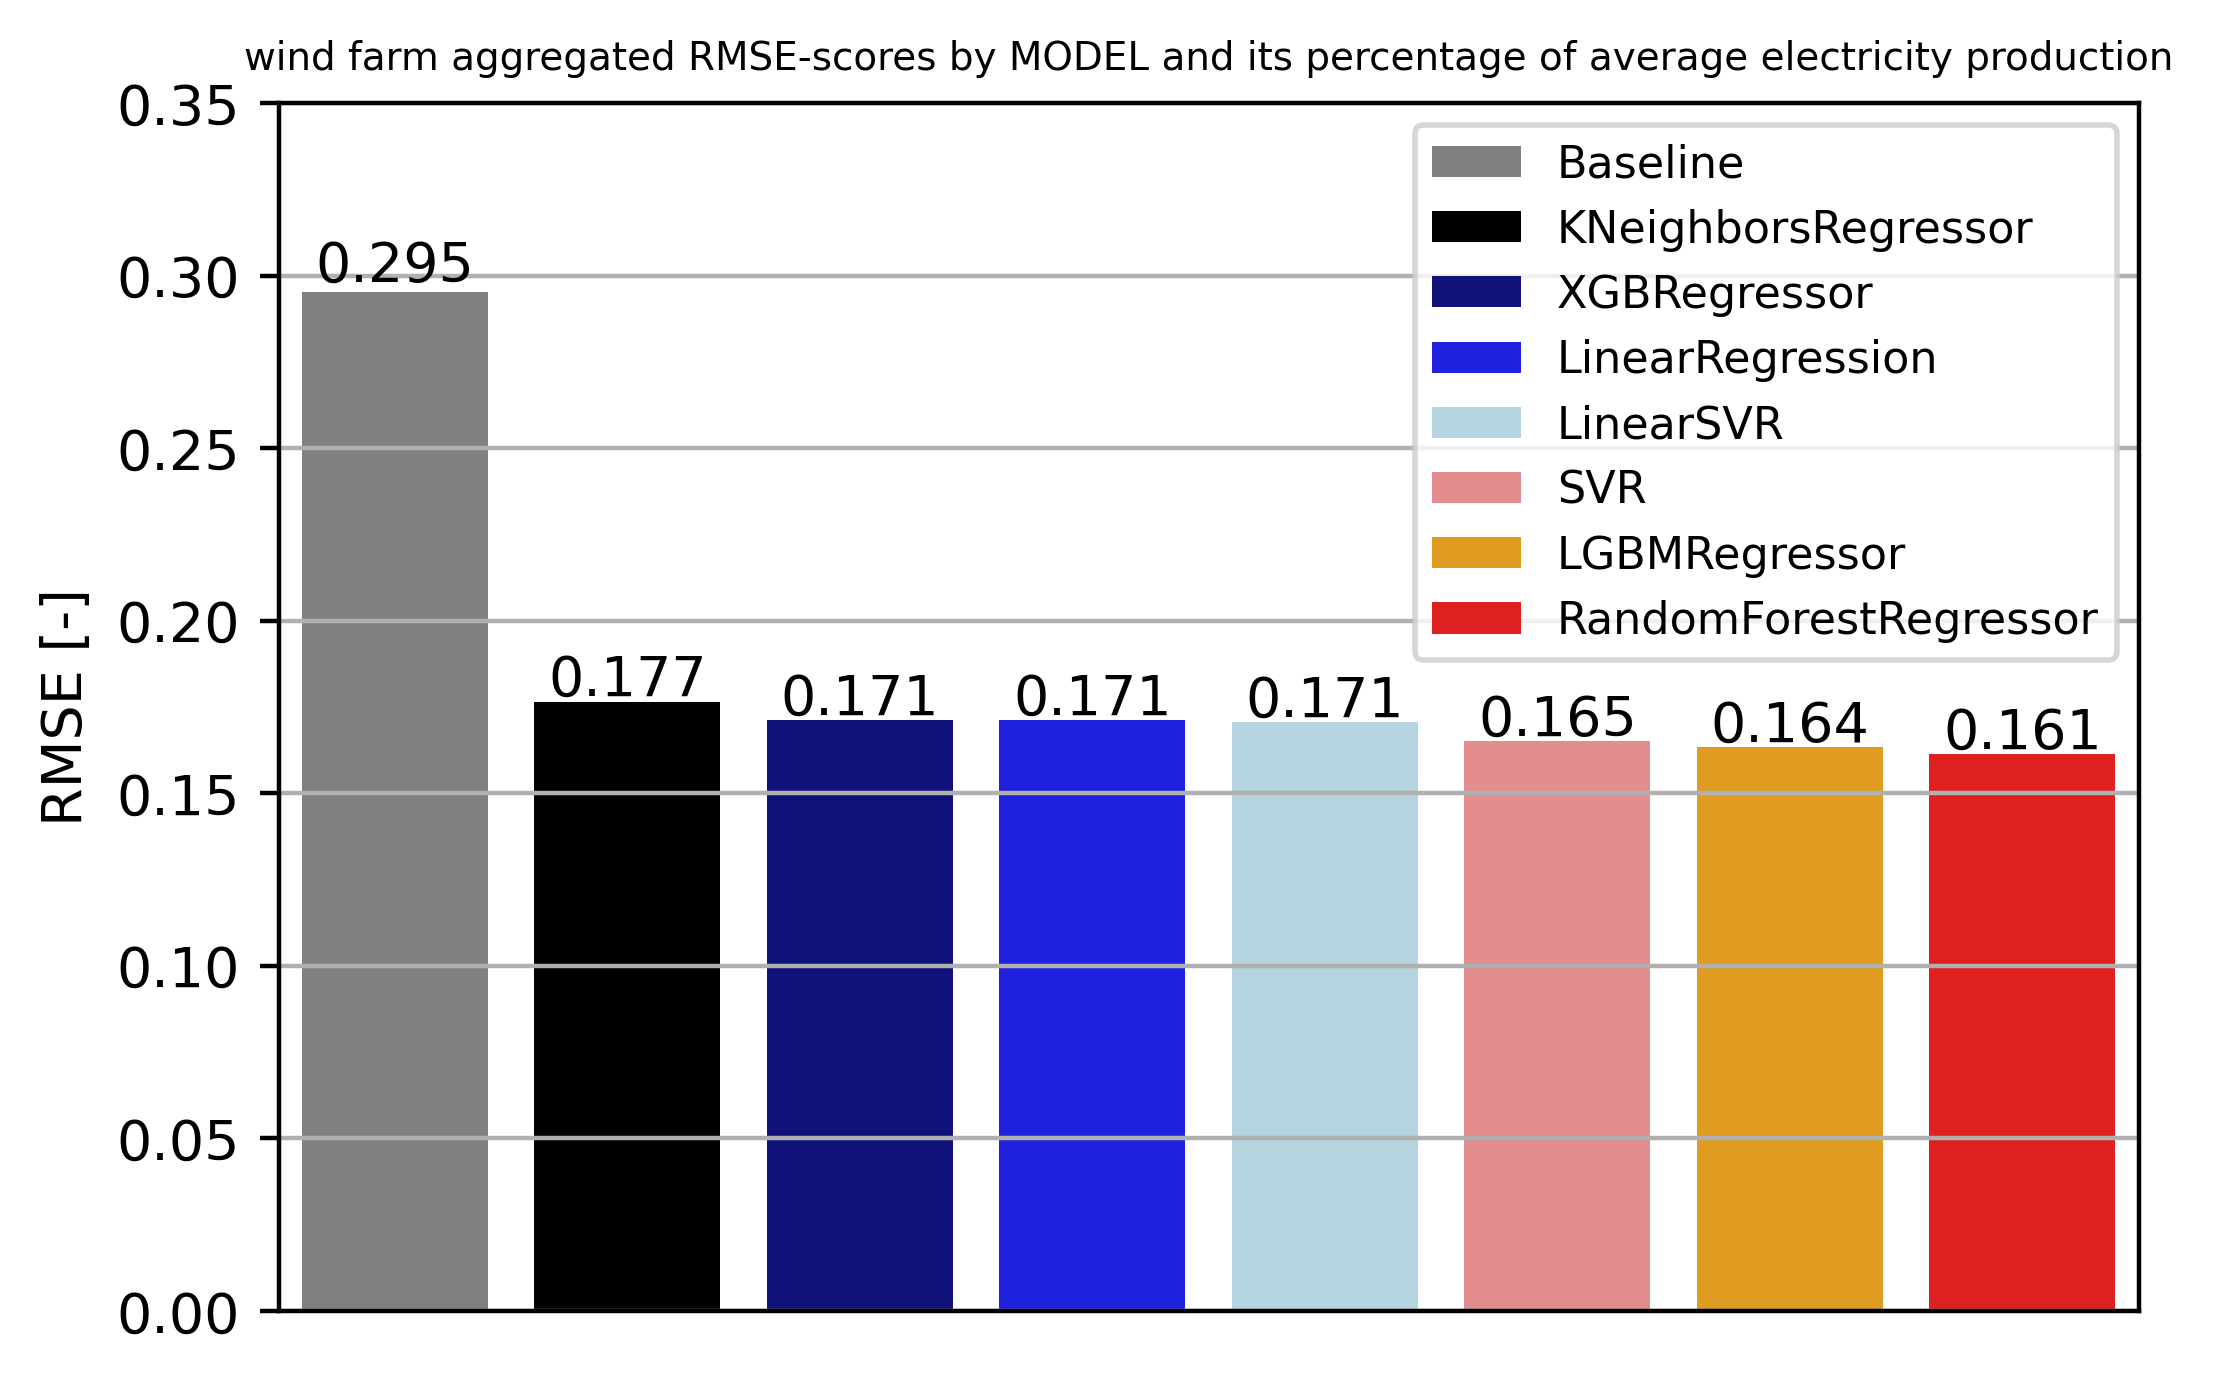

In [21]:
total = total.sort_values(by='VALSCORE', ascending=False)
total.index.set_names('MODEL', inplace=True)
total.reset_index(inplace=True)
fontsize=10
palette = ['gray', 'k', 'darkblue', 'b', 'lightblue', 'lightcoral', 'orange', 'r']
fig, ax = plt.subplots(dpi=400, figsize=(6,4))
bp = sns.barplot(data = total, x = 'MODEL', y = 'VALSCORE', hue = 'MODEL', ax=ax, dodge=False, palette = palette)
ax.yaxis.grid()
#ax.set_xlabel('MODELS', fontsize=fontsize)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.tick_params(axis='y', bottom=False, labelsize=fontsize) 
#ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
ax.tick_params(bottom=False)
ax.set(xticklabels=[])
ax.set(xlabel=None) #, labelsize=fontsize)
plt.legend(frameon=True, fontsize=fontsize-2)
ax.set_ylim([.0,.35]);

for index, row in total.iterrows():
    bp.text(row.name, row.VALSCORE + row.VALSCORE/100, '{:.3f}'.format(row.VALSCORE), ha='center', fontsize=fontsize)

ax.set_title('wind farm aggregated RMSE-scores by MODEL and its percentage of average electricity production', fontsize=fontsize-3);

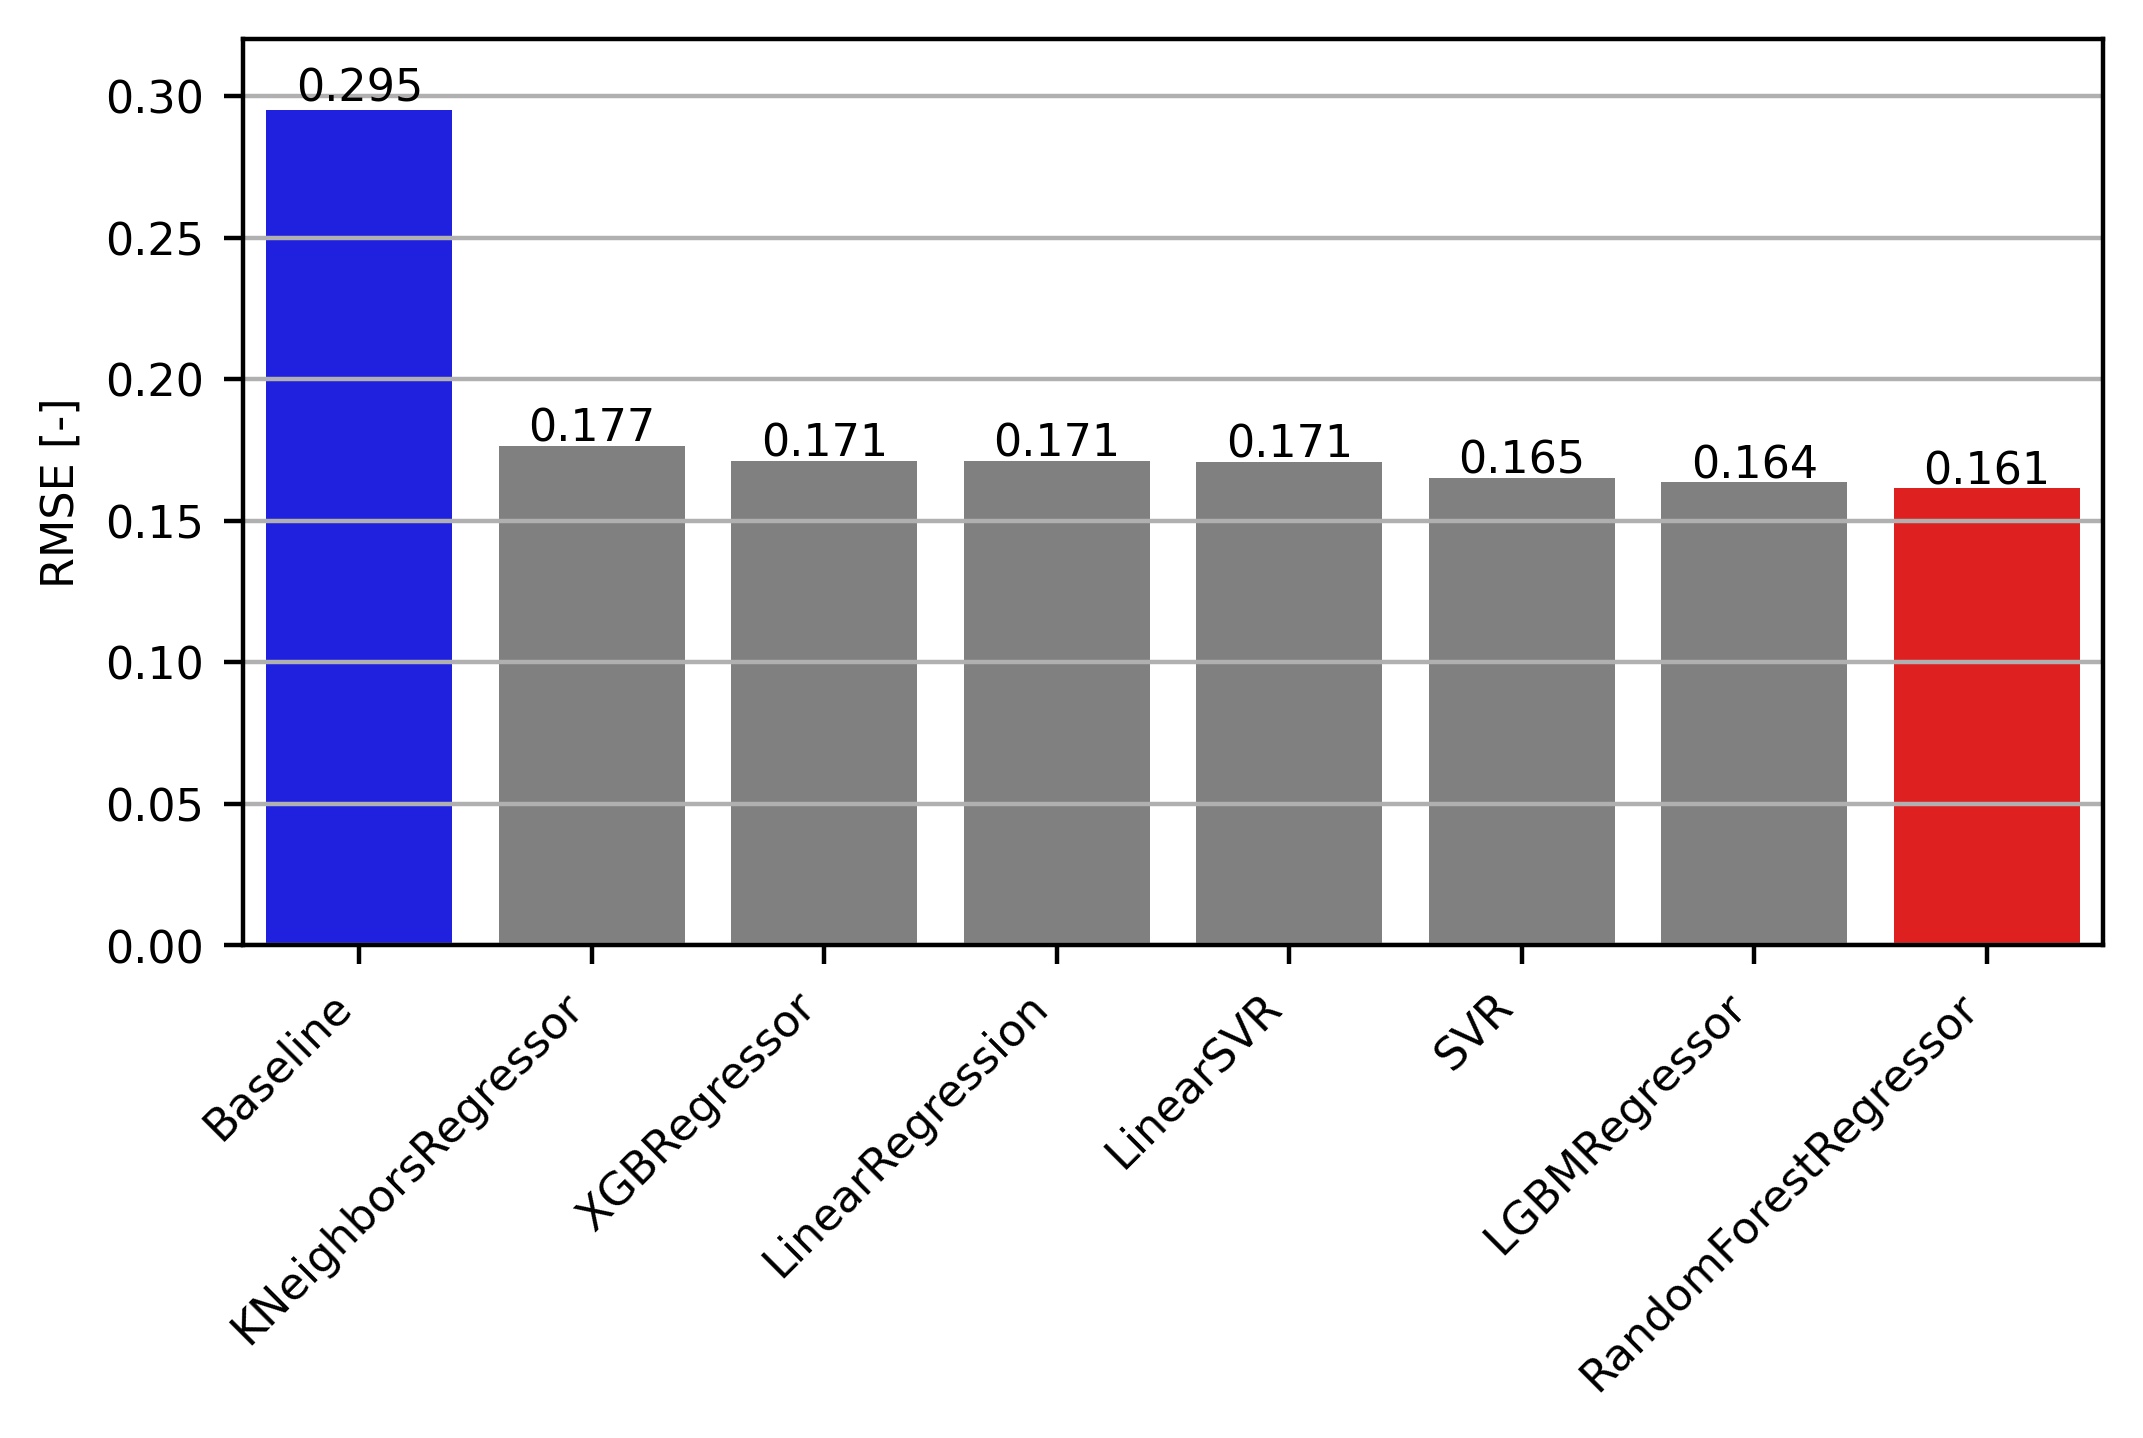

In [37]:
models = ['Baseline','LinearRegression', 'KNeighborsRegressor', 'RandomForestRegressor','LinearSVR', 'SVR', 'LGBMRegressor', 'XGBRegressor']

total = pd.DataFrame(index = models, columns = ['TESTSCORE','VALSCORE', 'RELVAL'])

for model in models:
    df = pd.read_csv(f'../results/{model}.csv', index_col='ZONE')
    if model != 'Baseline':
        total.loc[model]['TESTSCORE'] = np.sqrt(np.mean(df.TESTSCORE**2))
        total.loc[model]['VALSCORE'] = np.sqrt(np.mean(df.CV**2))
    else:
        total.loc[model]['VALSCORE'] = df.loc['TOTAL'].TRAINSCORE
        total.loc[model]['TESTSCORE'] = df.loc['TOTAL'].TESTSCORE
    total.loc[model]['RELVAL'] = total.loc[model]['VALSCORE'] / data_train.TARGETVAR.mean()
#total = total.sort_values(by='VALSCORE', ascending=False)

total = total.sort_values(by='VALSCORE', ascending=False)
total.index.set_names('MODEL', inplace=True)
total.reset_index(inplace=True)
fontsize=8
palette = ['blue', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'red']
alpha = [1.,.5,.5,.5,.5,.5,.5,1.]

fig, ax = plt.subplots(dpi=400, figsize=(6,3))
bp = sns.barplot(data = total, x = 'MODEL', y = 'VALSCORE', ax=ax, dodge=False, palette = palette, alpha = 1.)
ax.yaxis.grid()
#ax.set_xlabel('MODELS', fontsize=fontsize)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.tick_params(axis='y', bottom=False, labelsize=fontsize) 
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right', fontsize=fontsize)
#ax.tick_params(bottom=False)
#ax.set(xticklabels=[])
ax.set(xlabel=None) #, labelsize=fontsize)
#plt.legend(frameon=True, fontsize=fontsize-2)
ax.set_ylim([.0,.32]);

for index, row in total.iterrows():
    bp.text(row.name, row.VALSCORE + row.VALSCORE/100, '{:.3f}'.format(row.VALSCORE), ha='center', fontsize=fontsize)

#ax.set_title('wind farm aggregated RMSE-scores by MODEL and its percentage of average electricity production', fontsize=fontsize-3);

In [67]:
total #.TESTSCORE

,MODEL,TESTSCORE,VALSCORE,RELVAL
0,Baseline,0.330601,0.295229,0.86735
1,KNeighborsRegressor,0.184259,0.176524,0.518607
2,XGBRegressor,0.18147,0.171247,0.503104
3,LinearRegression,0.180694,0.171189,0.502935
4,LinearSVR,0.179668,0.170679,0.501436
6,LGBMRegressor,0.174265,0.16352,0.480402
5,SVR,0.173216,0.165114,0.485087
7,RandomForestRegressor,0.172724,0.161405,0.47419


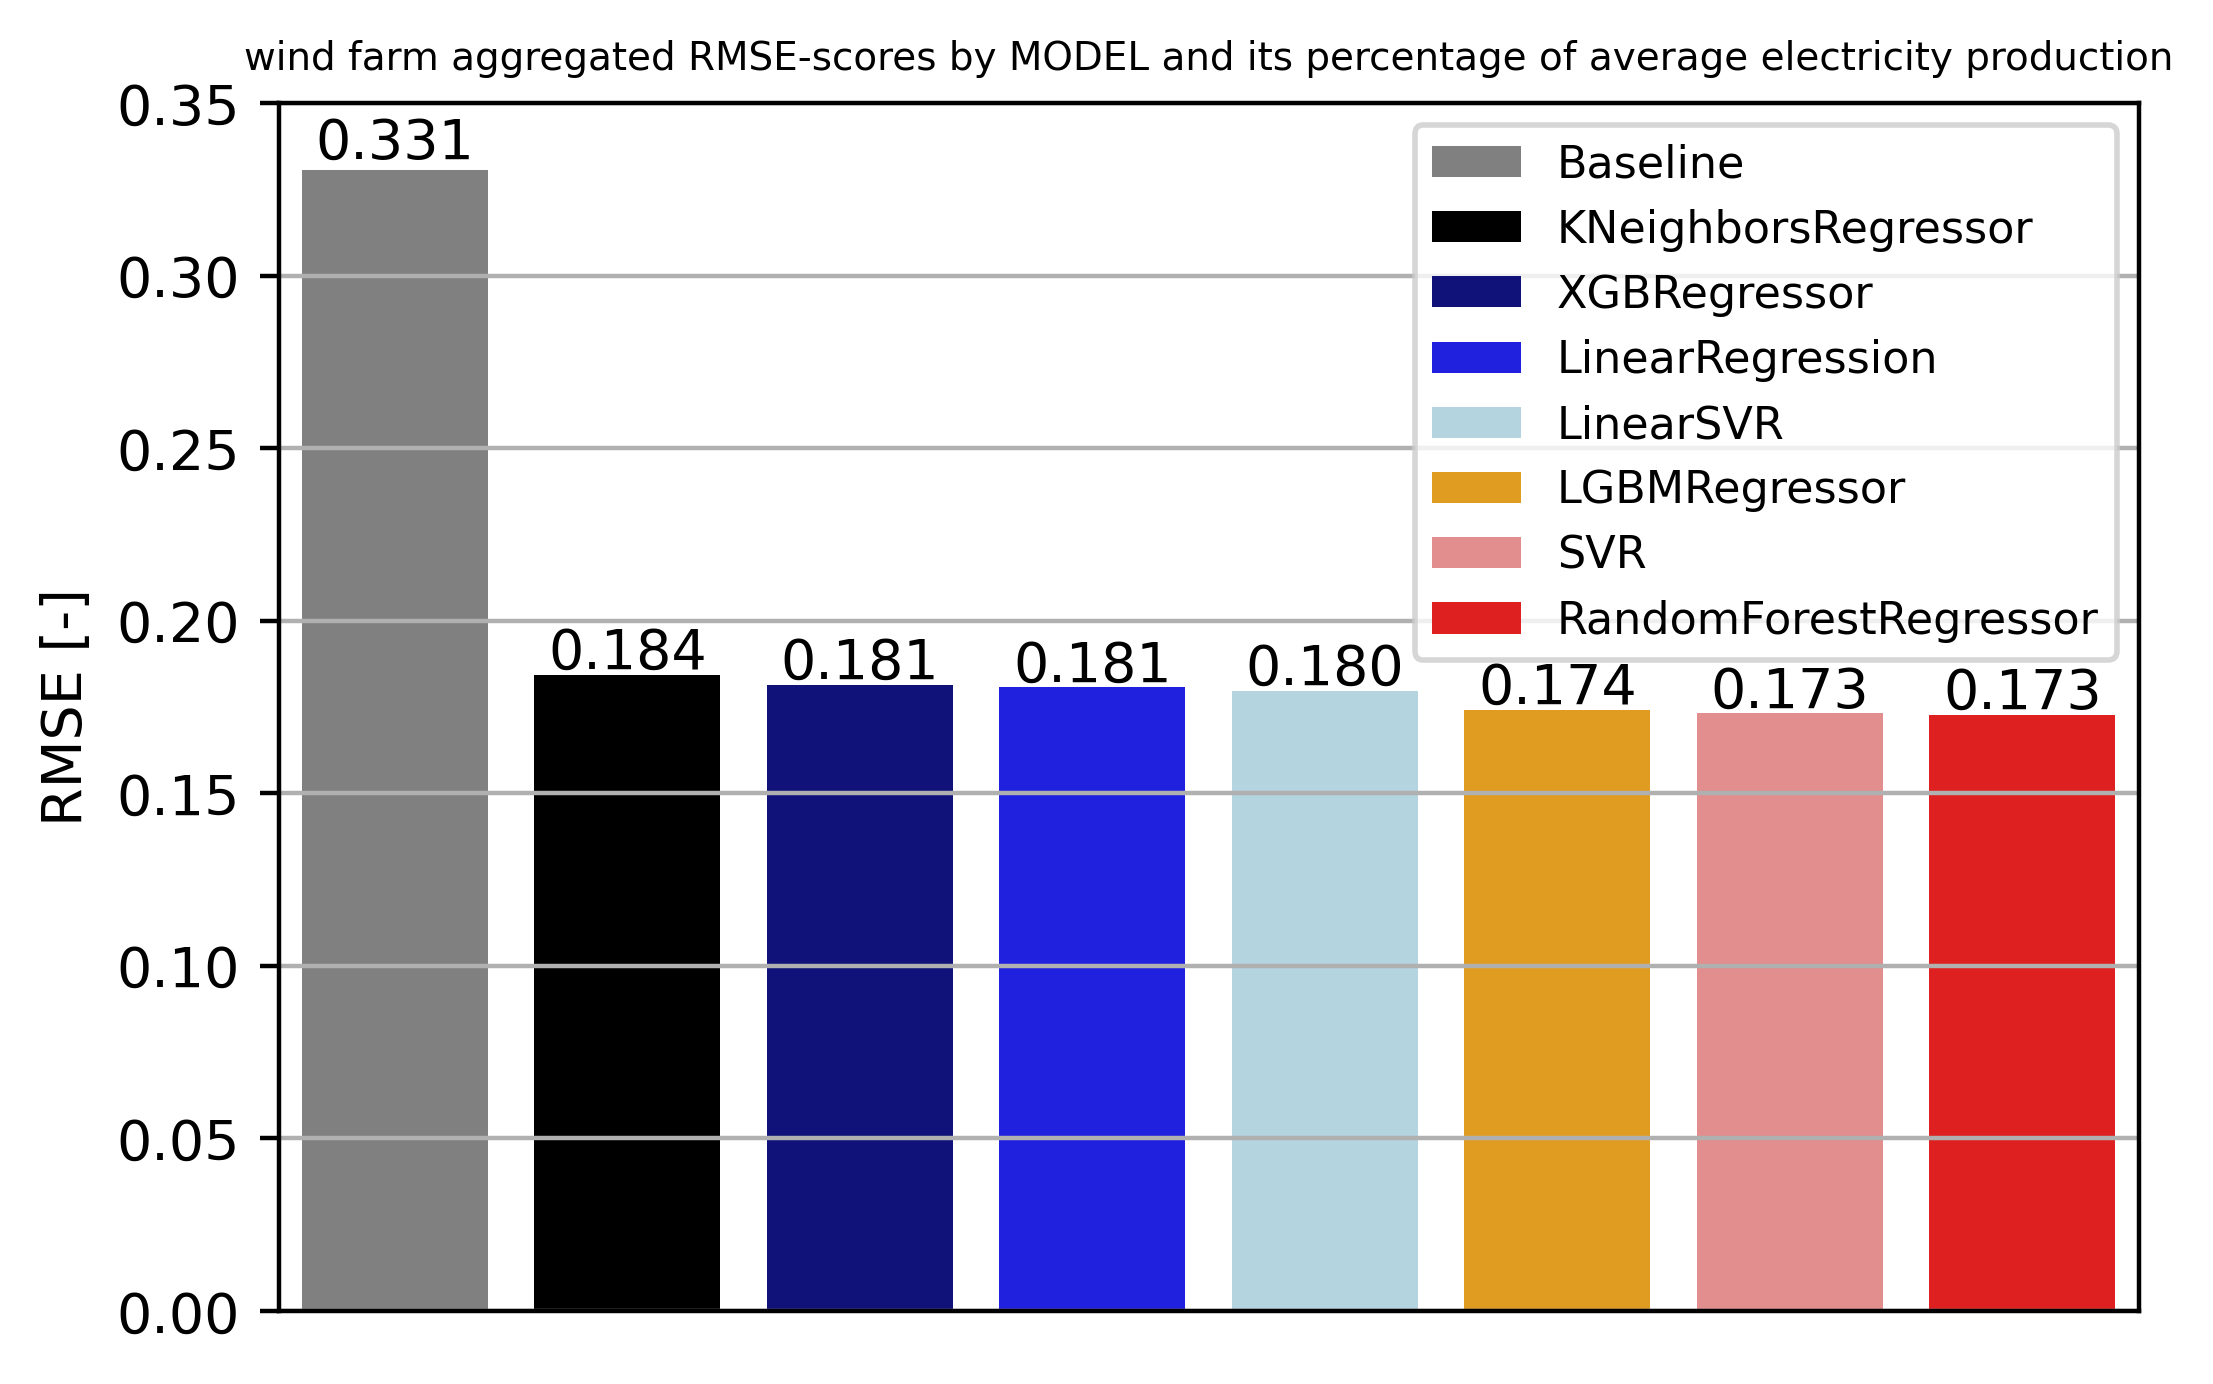

In [99]:
total = total.sort_values(by='TESTSCORE', ascending=False) 
total.index.set_names('MODEL', inplace=True)
total = total.reset_index()
fontsize=10
palette = ['gray', 'k', 'darkblue', 'b', 'lightblue', 'orange', 'lightcoral', 'r']
fig, ax = plt.subplots(dpi=400, figsize=(6,4))
bp = sns.barplot(data = total, x = 'MODEL', y = 'TESTSCORE', hue = 'MODEL', ax=ax, dodge=False, palette = palette)
ax.yaxis.grid()
#ax.set_xlabel('MODELS', fontsize=fontsize)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.tick_params(axis='y', bottom=False, labelsize=fontsize) 
#ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
ax.tick_params(bottom=False)
ax.set(xticklabels=[])
ax.set(xlabel=None) #, labelsize=fontsize)
plt.legend(frameon=True, fontsize=fontsize-2)
ax.set_ylim([.0,.35]);

for index, row in total.iterrows():
    bp.text(row.name, row.TESTSCORE + row.TESTSCORE/100, '{:.3f}'.format(round(row.TESTSCORE,3)), ha='center', fontsize=fontsize)

ax.set_title('wind farm aggregated RMSE-scores by MODEL and its percentage of average electricity production', fontsize=fontsize-3);

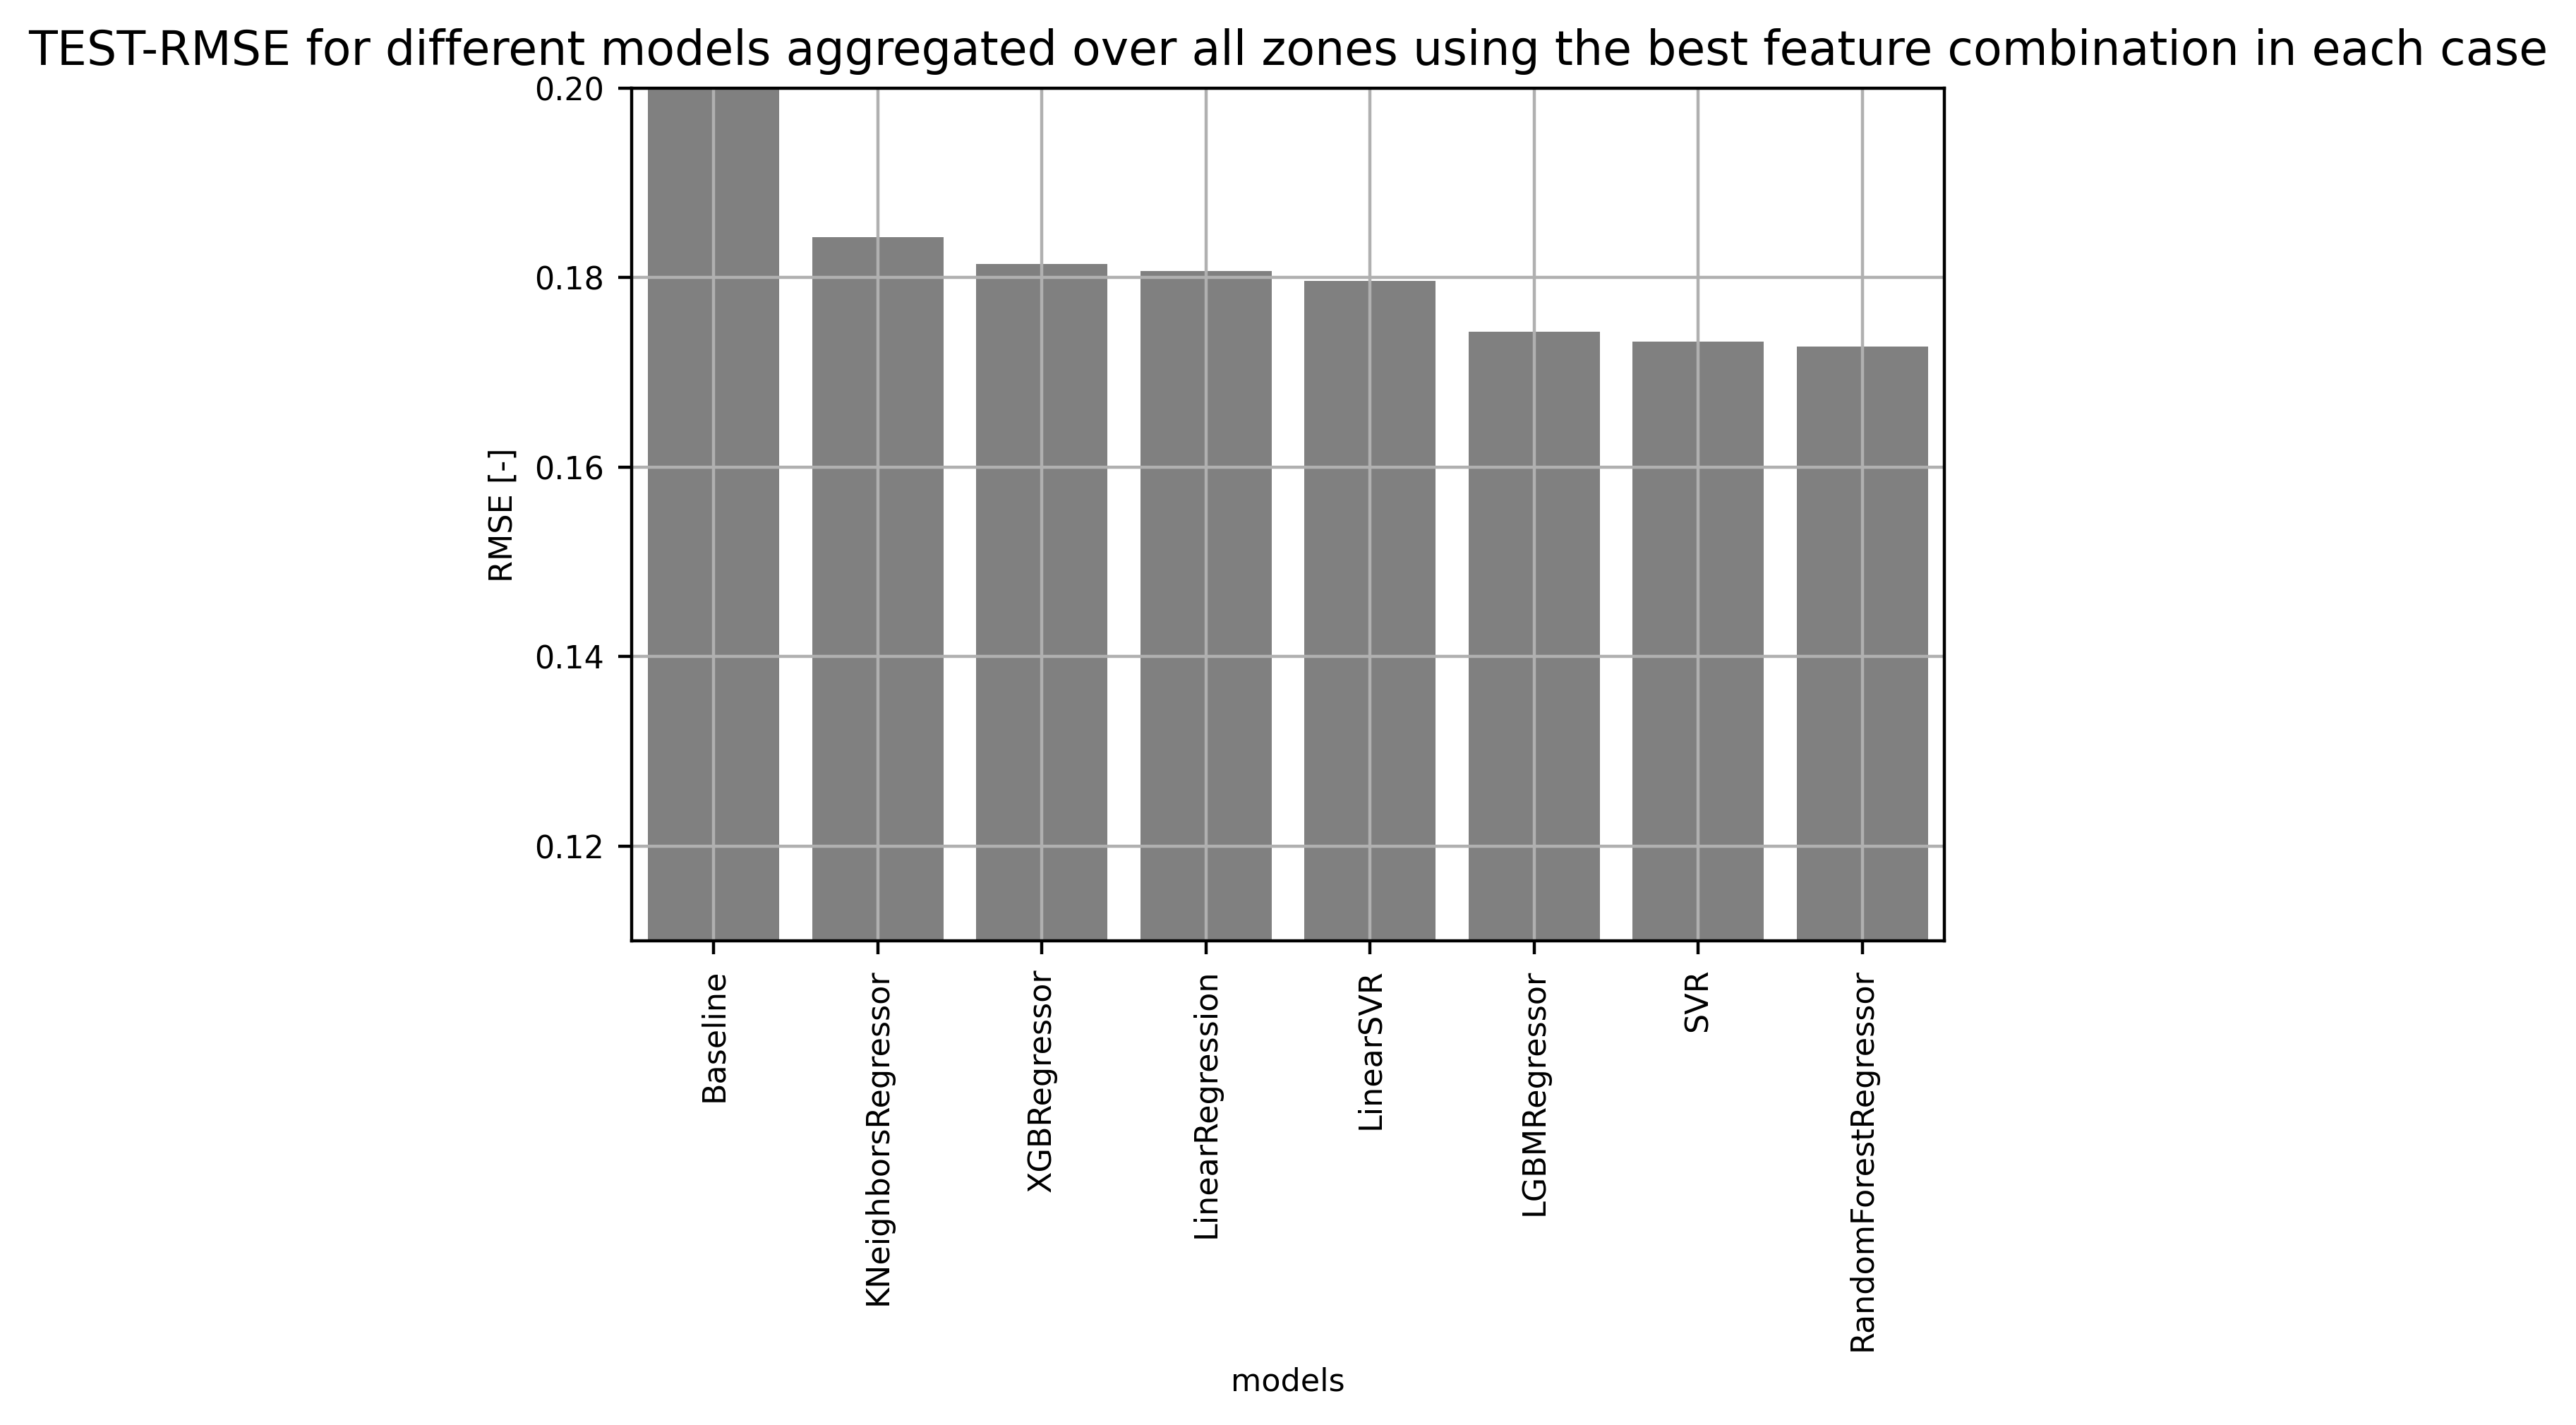

In [32]:
total = total.sort_values(by='TESTSCORE', ascending=False)
fig, ax = plt.subplots(dpi=400)
sns.barplot(data = total, x = total.index, y = 'TESTSCORE', color = 'gray', ax=ax)
ax.grid()
ax.set_xlabel('models', fontsize=fontsize)
ax.set_ylabel('RMSE [-]', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize) 
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
ax.set_ylim([.11,.20])
ax.set_title('TEST-RMSE for different models aggregated over all zones using the best feature combination in each case');

In [19]:
#total = total.sort_values(by='TESTSCORE', ascending=False)